In [1]:
import os
import time

from utilities import (extract_image_paths_from_pdf, extract_xml_from_digital_pdf, 
                       extract_html_bg_images_from_digital_pdf, create_directory, read_directory_files
                      )
from xml_document_info import (get_xml_info, get_xml_image_info)

from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy

from ocr_text_utilities import extract_text_from_image
from tables_lines_identifier import TableAndLine

## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [3]:
base_dir   = '/Users/kd/Workspace/python/github/document-structure/data/'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = '1506.02640.pdf'


## extract pdfs', background image, each page & xml information

In [4]:
pdf_filepath      = os.path.join(input_dir, filename)
working_dir       = os.path.join(output_dir, os.path.splitext(filename)[0])

ret               = create_directory(working_dir)

start_time        = time.time()

pdf_image_paths   = extract_image_paths_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir       = extract_xml_from_digital_pdf(pdf_filepath, working_dir)
pdf_bg_image_dir  = extract_html_bg_images_from_digital_pdf(pdf_filepath, working_dir)

end_time          = time.time()
extraction_time   = end_time - start_time

In [5]:
xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
bg_files       = read_directory_files(pdf_bg_image_dir, pattern='*.png')

print("Extracted xml, background images & images of file: %s" % (filename))
print('Extraction time (%f) average extraction time (%f)' % (extraction_time, extraction_time/len(bg_files)))

Extracted xml, background images & images of file: 1506.02640.pdf
Extraction time (4.804414) average extraction time (0.480441)


In [6]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])
img_dfs, page_width, page_height = get_xml_image_info(xml_files[0])


Total number of pages (10) in file (1506.02640.xml)
Total number of pages (10) in file (1506.02640.xml)


In [7]:
document_configs = {
    'LANGUAGE_TYPE': 'eng',
    
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [8]:
file_index      = 0

img_filepath    = pdf_image_paths[file_index]
bg_img_filepath = bg_files[file_index]
df              = xml_dfs[file_index]
img_df          = img_dfs[file_index]

In [9]:
# tblLines            = TableAndLine(bg_img_filepath)
# t_df, line_df, tables_df  = tblLines.get_tables_and_lines()
# table_childern_df   = tblLines.get_table_details(tables_df)
# # draw_box(img_filepath, page_width, page_height, table_df, color='red')


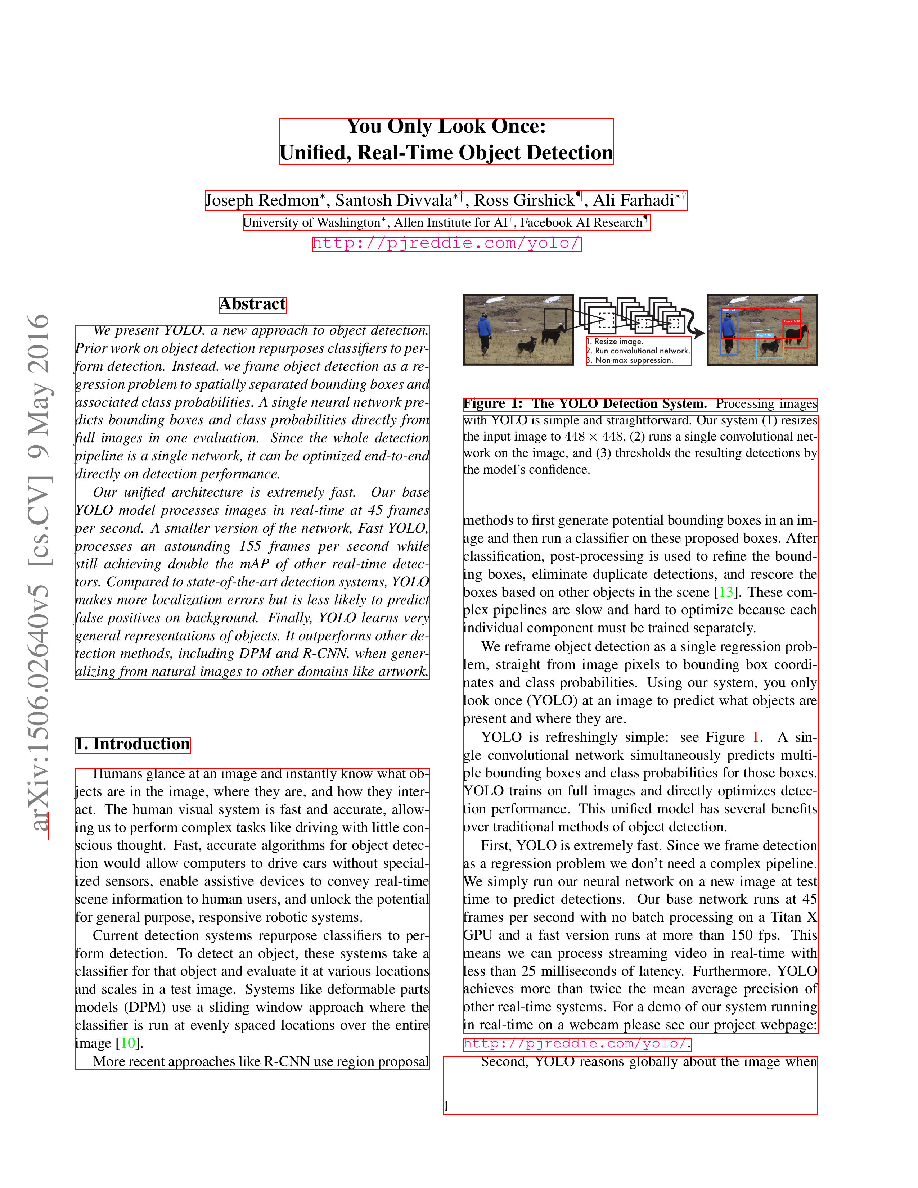

In [10]:

in_df   = df #.loc[10:30]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)

if document_configs['LANGUAGE_TYPE']  == 'hin':
    h_df  = extract_text_from_image(img_filepath, page_width, page_height, h_df, 
                                    lang=document_configs['LANGUAGE_TYPE'])

v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

draw_box(img_filepath, page_width, page_height, v_df, color='red')
# show_df(in_df)


In [11]:
in_df.loc[(in_df['text_top'] >= table_df.loc[0]['text_top']) & 
          (in_df['text_left'] >= table_df.loc[0]['text_left']) &
          (in_df['text_height'] <= table_df.loc[0]['text_height']) &
          (in_df['text_width'] <= table_df.loc[0]['text_width'])
         ]


,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib
1,1,1197,439,19,12,25,13,Arial,#000000,
26,26,913,229,450,17,DETAILS OF WOMEN OFFICERS IN INDIAN ARMY,18,"Arial,Bold",#000000,
27,27,957,117,149,17,Present Holding,18,"Arial,Bold",#000000,
28,28,957,308,124,17,Above 20 Yrs,18,"Arial,Bold",#000000,
29,29,957,465,331,17,Between 14-20 Yrs Fate Undecided,18,"Arial,Bold",#000000,
30,30,1001,168,47,17,1653,18,"Arial,Bold",#000000,
31,31,1001,357,26,17,77,18,"Arial,Bold",#000000,
32,32,1001,533,37,17,255,18,"Arial,Bold",#000000,
33,33,1001,706,37,17,332,18,"Arial,Bold",#000000,
34,34,1088,108,31,17,38.,18,Arial,#000000,
